In [2]:
import pysm3
import pysm3.units as u
import healpy as hp
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import math
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))
# make sure the version and path is what you expect

Using CAMB 1.5.2 installed at /Users/ikumakiyoshi/.julia/conda/3/lib/python3.10/site-packages/camb


In [3]:
nside = 2**2

In [4]:
#Set up a new set of parameters for CAMB
pars = camb.read_ini('params_camb_for_PTEP.ini')
#Set WantTensors to True
pars.WantTensors = True
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=1)
pars.set_for_lmax(3*nside + 1, lens_potential_accuracy=0)
random_seed = 5123
pars.RandomSeed = random_seed;

In [5]:
#calculate results for these parameters
results = camb.get_results(pars)

#get dictionary of CAMB power spectra
powers =results.get_cmb_power_spectra(pars, lmax = 3*nside + 1, CMB_unit='muK', raw_cl=True)
for name in powers: print(name)

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential


In [6]:
cl_scal = powers['unlensed_scalar']
cl_tens = powers['tensor']
cl_lens = powers['lensed_scalar']
cl_pot = powers['lens_potential']
cl_total = powers['total']

r = 10**-1

cl = cl_scal + r * cl_tens + cl_lens

#without lense
#cl = cl_scal + r * cl_tens

In [7]:
import healpy as hp
seed = 12345
np.random.seed(seed)
cmb_map = hp.synfast(cl.T, nside, new = True)

In [8]:
import warnings
warnings.filterwarnings("ignore")

c1: A lensed CMB realisation is computed using Taylens, a code to compute a lensed CMB realisation using nearest-neighbour Taylor interpolation (taylens; Naess, S. K. and Louis, T. JCAP 09 001, 2013, astro-ph/1307.0719). This code takes, as an input, a set of unlensed Cl’s generated using CAMB. The params.ini is in the Ancillary directory.

In [9]:
Synch = pysm3.Sky(nside, preset_strings=["s1"])
Dust = pysm3.Sky(nside, preset_strings=["d1"])

In [10]:
Synch.components, Dust.components

([<pysm3.models.power_law.PowerLaw at 0x163169660>],
 [<pysm3.models.dust.ModifiedBlackBody at 0x16316b430>])

In [11]:
map_Synch_40GHz = Synch.get_emission(40 * u.GHz)
map_Synch_140GHz = Synch.get_emission(140 * u.GHz)
map_Dust_402GHz = Dust.get_emission(402 * u.GHz)
map_Dust_140GHz = Dust.get_emission(140 * u.GHz)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [12]:
map_Synch_40GHz = map_Synch_40GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(40*u.GHz))
map_Synch_140GHz = map_Synch_140GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(140*u.GHz))
map_Dust_402GHz = map_Dust_402GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(402*u.GHz))
map_Dust_140GHz = map_Dust_140GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(140*u.GHz))

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
#hp.mollview(map_Synch_40GHz[0], title=" map", unit = map_Synch_40GHz.unit)
#hp.mollview(map_Synch_140GHz[0], title=" map", unit = map_Synch_140GHz.unit)
#hp.mollview(map_Dust_402GHz[0], title=" map", unit = map_Dust_402GHz.unit)
#hp.mollview(map_Dust_140GHz[0], title=" map", unit = map_Dust_140GHz.unit)

## Clean MAP

In [15]:
N_pix = hp.nside2npix(nside)

## $\vec{m} = ({[Q,U]_{\nu_1}(\hat{n}_i)},...,{[Q,U]_{\nu_{Nfreq}}(\hat{n}_{i})})$

In [16]:
# Data m

data_m = pysm3.Sky(nside, preset_strings=["d1"])

## $\vec{m}$ for each channel

In [17]:
m_40GHz = data_m.get_emission(40 * u.GHz)
m_140GHz = data_m.get_emission(140 * u.GHz)
m_50GHz = data_m.get_emission(50 * u.GHz)
m_100GHz = data_m.get_emission(100 * u.GHz)
m_280GHz = data_m.get_emission(280 * u.GHz)
m_402GHz = data_m.get_emission(402 * u.GHz)

# μK_R to μK_CMB

m_40GHz = m_40GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(40*u.GHz)).value + cmb_map
m_140GHz = m_140GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(140*u.GHz)).value + cmb_map
m_50GHz = m_50GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(50*u.GHz)).value + cmb_map
m_100GHz = m_100GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(100*u.GHz)).value + cmb_map
m_280GHz = m_280GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(280*u.GHz)).value + cmb_map
m_402GHz = m_402GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(402*u.GHz)).value + cmb_map

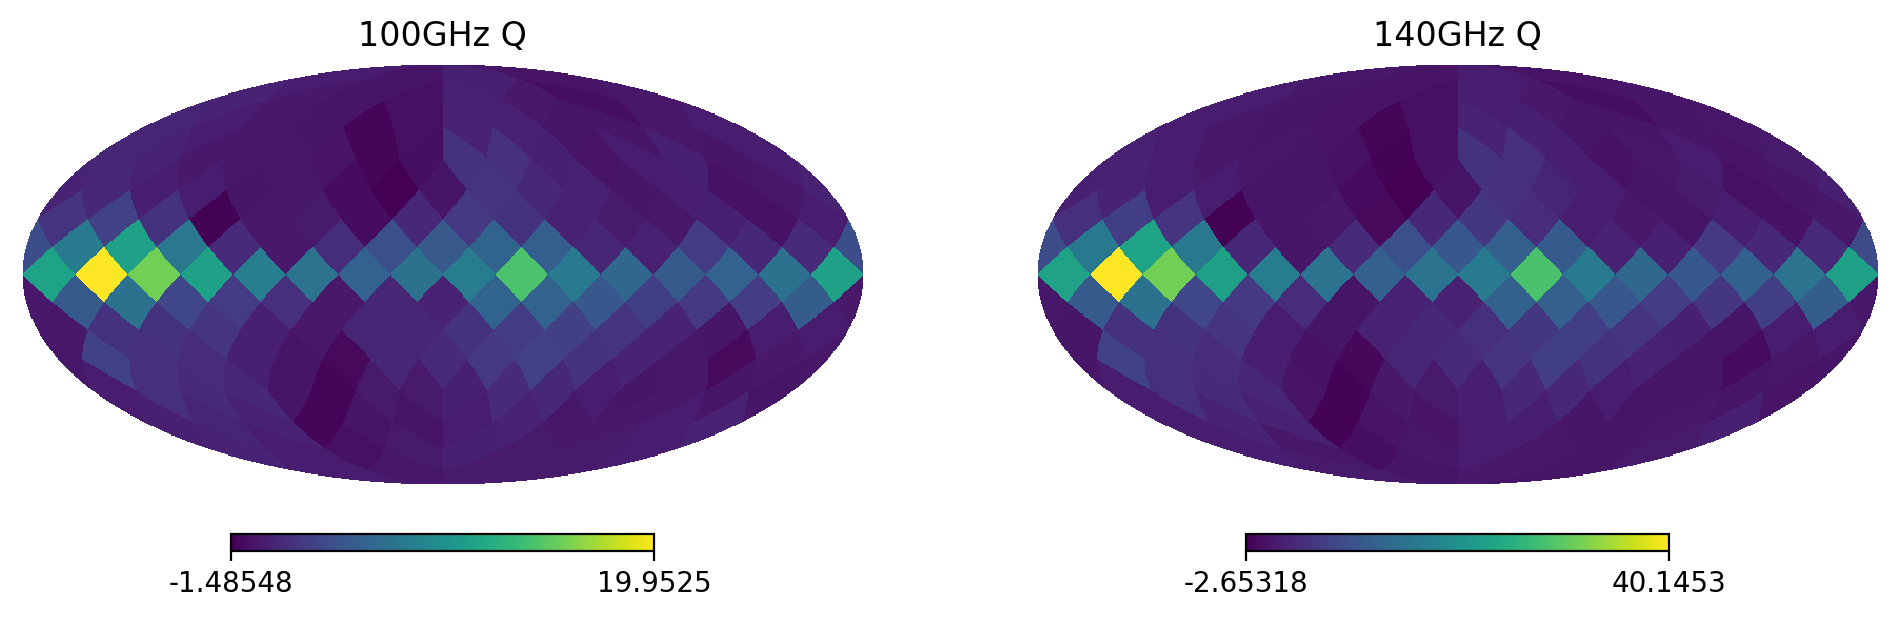

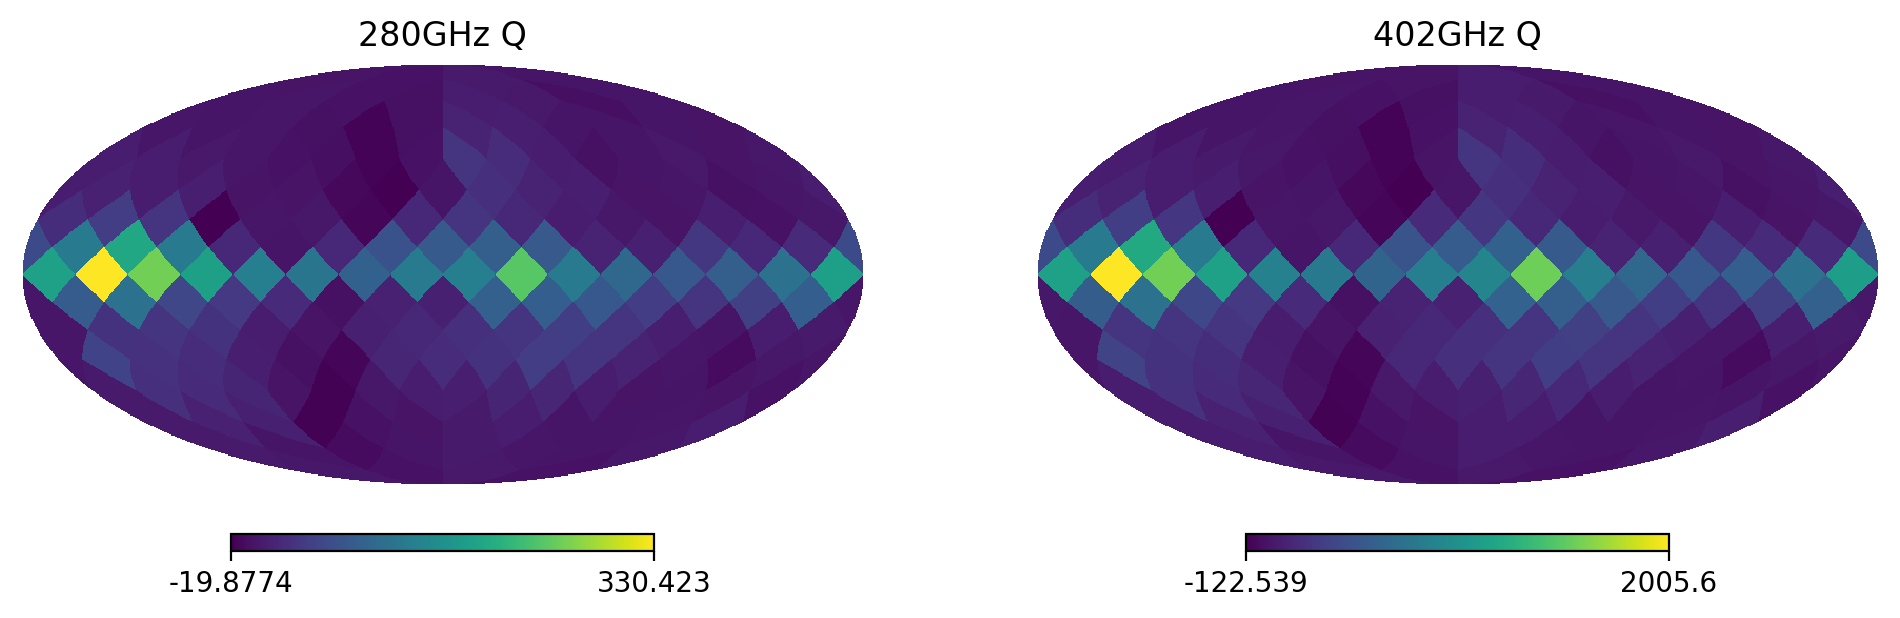

In [18]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

"""
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(m_40GHz[1], title="40GHz Q", hold=True)

plt.axes(ax2)
hp.mollview(m_50GHz[1], title="50GHz Q", hold=True)
"""

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(m_100GHz[1], title="100GHz Q",hold=True)

plt.axes(ax2)
hp.mollview(m_140GHz[1], title="140GHz Q",hold=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(m_280GHz[1], title="280GHz Q",hold=True)

plt.axes(ax2)
hp.mollview(m_402GHz[1], title="402GHz Q",hold=True)

## Q, U of m for each channel

In [19]:
m_40GHz_Q = m_40GHz[1]
m_50GHz_Q = m_50GHz[1]
m_100GHz_Q = m_100GHz[1]
m_140GHz_Q = m_140GHz[1]
m_280GHz_Q = m_280GHz[1]
m_402GHz_Q = m_402GHz[1]

m_40GHz_U = m_40GHz[2]
m_50GHz_U = m_50GHz[2]
m_100GHz_U = m_100GHz[2]
m_140GHz_U = m_140GHz[2]
m_280GHz_U = m_280GHz[2]
m_402GHz_U = m_402GHz[2]

##### $\vec{m} = [[Q,U]_{40GHz}(\hat{n}_{i}),[Q,U]_{100GHz}(\hat{n}_{i}),[Q,U]_{140GHz}(\hat{n}_{i})]^T$

In [20]:
data_m = np.concatenate((m_100GHz_Q ,m_100GHz_U, m_140GHz_Q ,m_140GHz_U, m_280GHz_Q ,m_280GHz_U, m_402GHz_Q ,m_402GHz_U), axis=0).T

#print(len(data_m))

#### $\boldsymbol{D}=[\boldsymbol{D}^{CMB},\boldsymbol{D}^{Dust}(\bar{\beta_d},\bar{T_d}),\boldsymbol{D}^{Dust}_{,\beta},\boldsymbol{D}^{Dust}_{,T_d}]$

<img src="D_1.png" width="450"><img src="D.png" width="450">

## D elements

### $\nu_{d*} = 353$ GHz   , $\beta_d = 1.5$, $T_d = 20.1$ K

In [21]:
def D_element(freq, freq_bs = 23*10**9, beta_s = -3., freq_bd = 353*10**9, beta_d = 1.54, T_d =20):

    # x = (f / T) * (h / k)
    x = (freq / 2.725) / (2.083661912 * 10**10)
    
    g_freq = ((np.exp(x) - 1)**2) / (np.exp(x) * x**2) * 1000.0
    
    s = g_freq * (freq/freq_bs)**(beta_s)
    
    ss = g_freq * (freq/freq_bs)**(beta_s) * np.log(freq/freq_bs)

    x_d = (freq / T_d) / (2.083661912 * 10**10)

    x_bd = (freq_bd / T_d) / (2.083661912 * 10**10)

    d = g_freq * (freq/freq_bd)**(beta_d + 1) * ((np.exp(x_bd)-1)/(np.exp(x_d)-1))

    dd = d * np.log(freq/freq_bd)

    ddd = d * (((x_d*np.exp(x_d))/(np.exp(x_d)-1)) - (x_bd*np.exp(x_bd))/(np.exp(x_bd)-1))/T_d
    
    return s, ss, d, dd, ddd

# freq_bs = 23 GHz, beta_s = -3.0
# freq_bd = 353 GHz   , beta_d = 1.5, T_d = 20.1 K

s_40, ss_40, d_40, dd_40, ddd_40 = D_element(40 * 10**9)

s_50, ss_50, d_50, dd_50, ddd_50 = D_element(50 * 10**9)

s_100, ss_100, d_100, dd_100, ddd_100 = D_element(100 * 10**9)

s_140, ss_140, d_140, dd_140, ddd_140 = D_element(140 * 10**9)

s_280, ss_280, d_280, dd_280, ddd_280 = D_element(280 * 10**9)

s_402, ss_402, d_402, dd_402, ddd_402 = D_element(402 * 10**9)

# D Matrix

diag = np.identity(2 * N_pix)

# Block Matrix, CMB + FG
D = np.block([
    [diag, d_100 * diag, dd_100 * diag, ddd_100 * diag],
    [diag, d_140 * diag, dd_140 * diag, ddd_140 * diag],
    [diag, d_280 * diag, dd_280 * diag, ddd_280 * diag],
    [diag, d_402 * diag, dd_402 * diag, ddd_402 * diag]
])

print(D.shape)

(1536, 1536)


In [22]:
#　make noise covariance matrix

N_freq = int(len(data_m) / N_pix)

diag = np.identity(N_pix)

noise = np.random.normal(loc=0., scale=1., size = N_pix)

noise_40 = diag * np.random.normal(loc=0., scale=1., size = N_pix)

noise_140 = diag * np.random.normal(loc=0., scale=1., size = N_pix)

#noise_nest = hp.pixelfunc.reorder(noise, inp='RING', out='NEST')

#hp.mollview(noise, title='noise')

In [23]:
x = np.zeros(N_pix)

## Calculate Clean Map

<img src="clean_map.png" width="450">


#### $N + 3 = N_{freq}$ $\Longrightarrow$ $CMB^{ML}(\hat{n})=[\boldsymbol{D}^{-1}\vec{m}]$

In [24]:
from numpy.linalg import solve as bslash

#CMB_map = bslash((D.T @ bslash(N, D)), D.T @ bslash (N, m))

# N + M +3 = Nfreq ===> just number of frequency bands (Synch + Dust)
# N + 2 = Nfreq ===> just number of frequency bands (Dust)
# M + 2 = Nfreq ===> just number of frequency bands (Synch)

clean_map = bslash(D, data_m)

### Power spectrum

In [25]:
CMB_map_Q = clean_map[N_pix*0:N_pix*1]
CMB_map_U = clean_map[N_pix*1:N_pix*2]

In [26]:
I = np.ones(N_pix)

Clean_map = [I, CMB_map_Q, CMB_map_U]

Input_map = [I, cmb_map[1], cmb_map[2]]

In [27]:
import math

Clean_map_cl = hp.sphtfunc.anafast(Clean_map)

Input_map_cl = hp.sphtfunc.anafast(Input_map)

l = np.arange(0, 3*nside, 1)

Clean_map_dl = Clean_map_cl * l * (l + 1) / (2 * math.pi)

Input_map_dl = Input_map_cl * l * (l + 1) / (2 * math.pi)

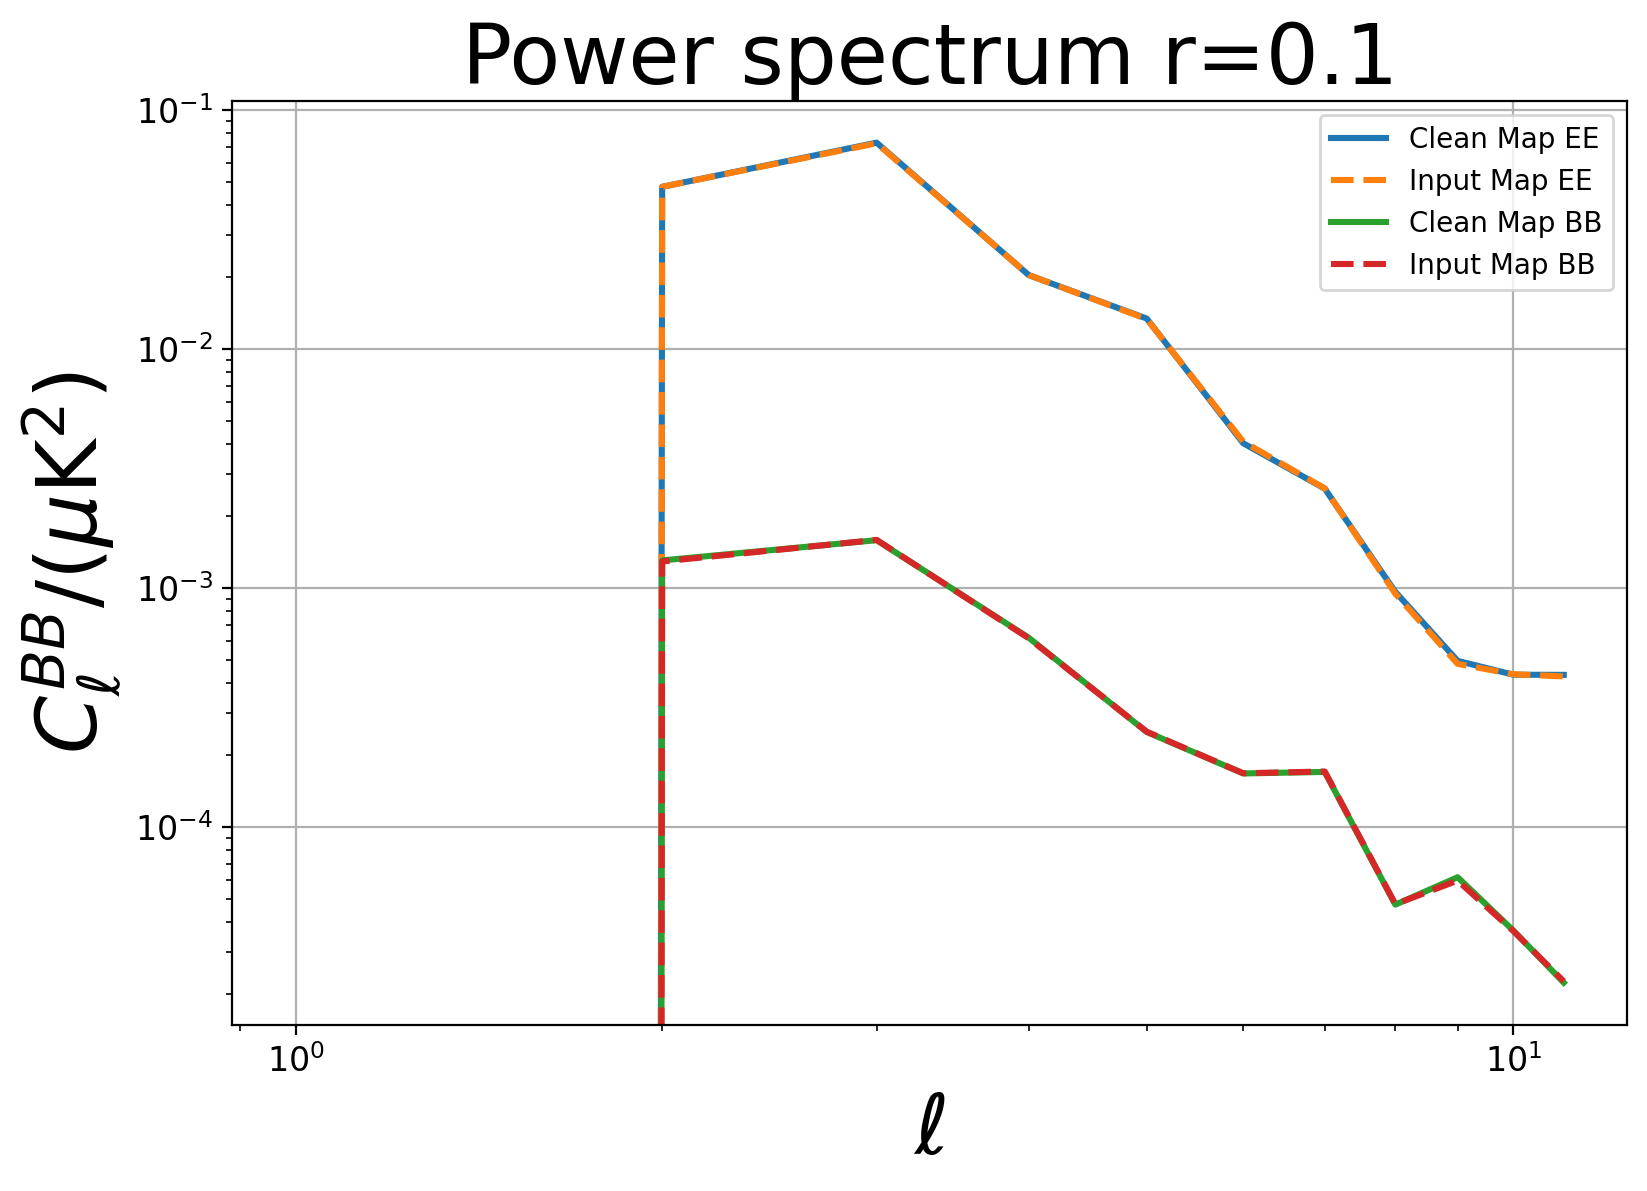

In [28]:
import matplotlib.pyplot as plt

#plot#
fig = plt.figure(figsize=(9, 6))

plt.loglog(l, Clean_map_cl[1] , lw = 2.2, label="Clean Map EE")
plt.loglog(l, Input_map_cl[1], lw=2.2, linestyle='dashed', label="Input Map EE")


plt.loglog(l, Clean_map_cl[2] , lw = 2.2, label="Clean Map BB")
plt.loglog(l, Input_map_cl[2], lw = 2.2, linestyle='dashed', label="Input Map BB")

plt.ylabel(r'$C_\ell^{BB}/ (\mu{\rm K}^2)$', fontsize=30)
plt.xlabel(r'$\ell$', fontsize=30)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title("Power spectrum r=" + str(r), fontsize=30)

plt.grid()
plt.legend()

#plt.savefig('Power_spectrum.png', bbox_inches='tight')
plt.show()

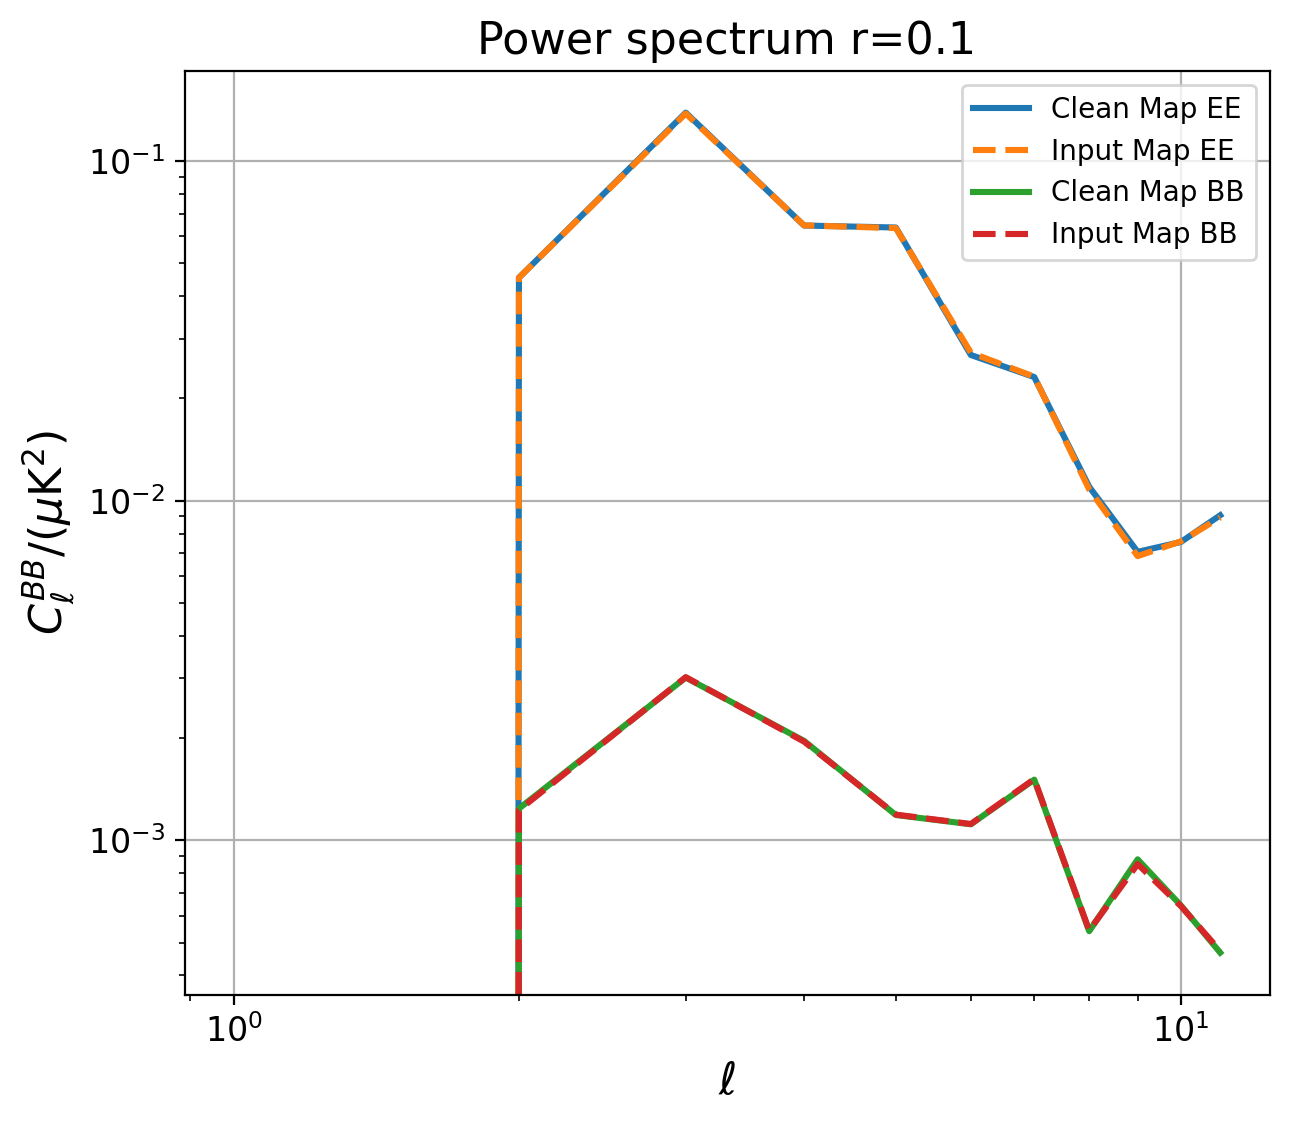

In [29]:
import matplotlib.pyplot as plt

#plot#
fig = plt.figure(figsize=(7, 6))

plt.loglog(l, Clean_map_dl[1] , lw = 2.2, label="Clean Map EE")
plt.loglog(l, Input_map_dl[1], lw=2.2, linestyle='dashed', label="Input Map EE")


plt.loglog(l, Clean_map_dl[2] , lw = 2.2, label="Clean Map BB")
plt.loglog(l, Input_map_dl[2], lw = 2.2, linestyle='dashed', label="Input Map BB")


plt.ylabel(r'$C_\ell^{BB}/ (\mu{\rm K}^2)$', fontsize=16)
plt.xlabel(r'$\ell$', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#plt.ylim(10**-12, 10**-0)

plt.title("Power spectrum r=" + str(r), fontsize=16)

plt.grid()
plt.legend()

#plt.savefig('Power_spectrum.png', bbox_inches='tight')
plt.show()

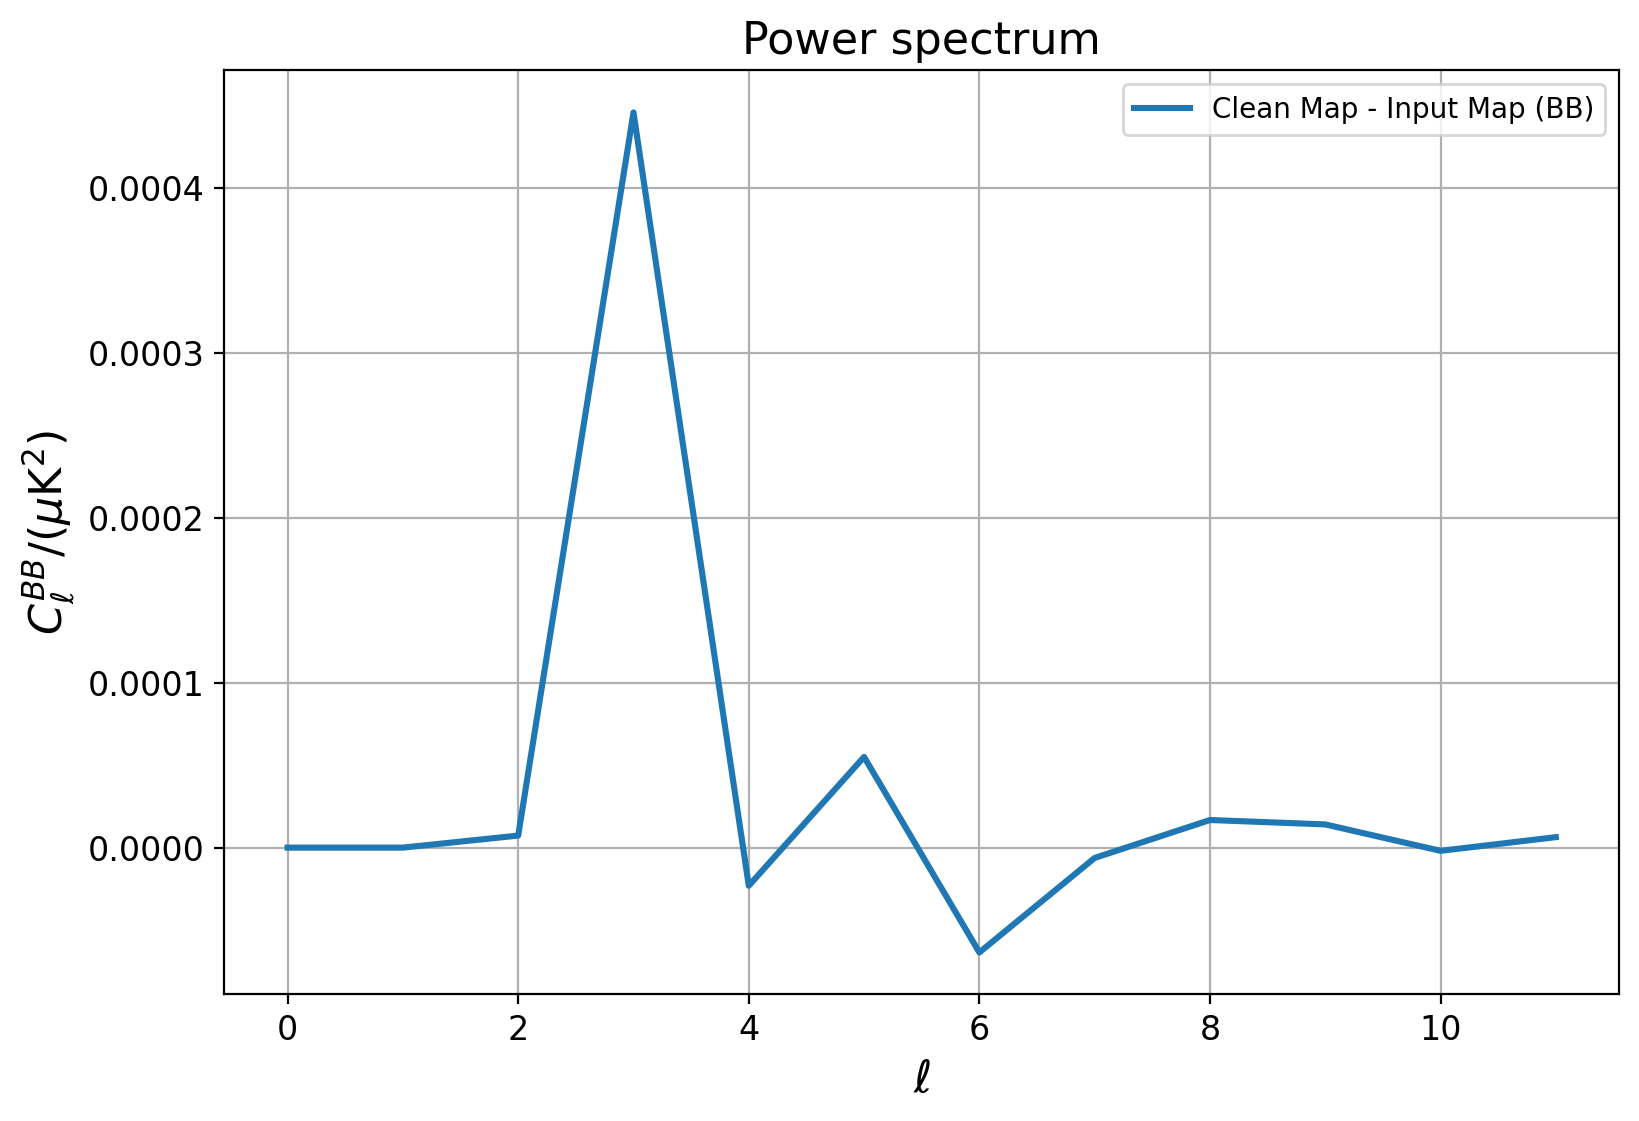

In [30]:
import matplotlib.pyplot as plt

#plot#
fig = plt.figure(figsize=(9, 6))

plt.plot(l, Clean_map_cl[1] - Input_map_cl[1] , lw = 2.2, label="Clean Map - Input Map (BB)")

plt.ylabel(r'$C_\ell^{BB}/ (\mu{\rm K}^2)$', fontsize=16)
plt.xlabel(r'$\ell$', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.title("Power spectrum", fontsize=16)

plt.grid()
plt.legend()

plt.show()

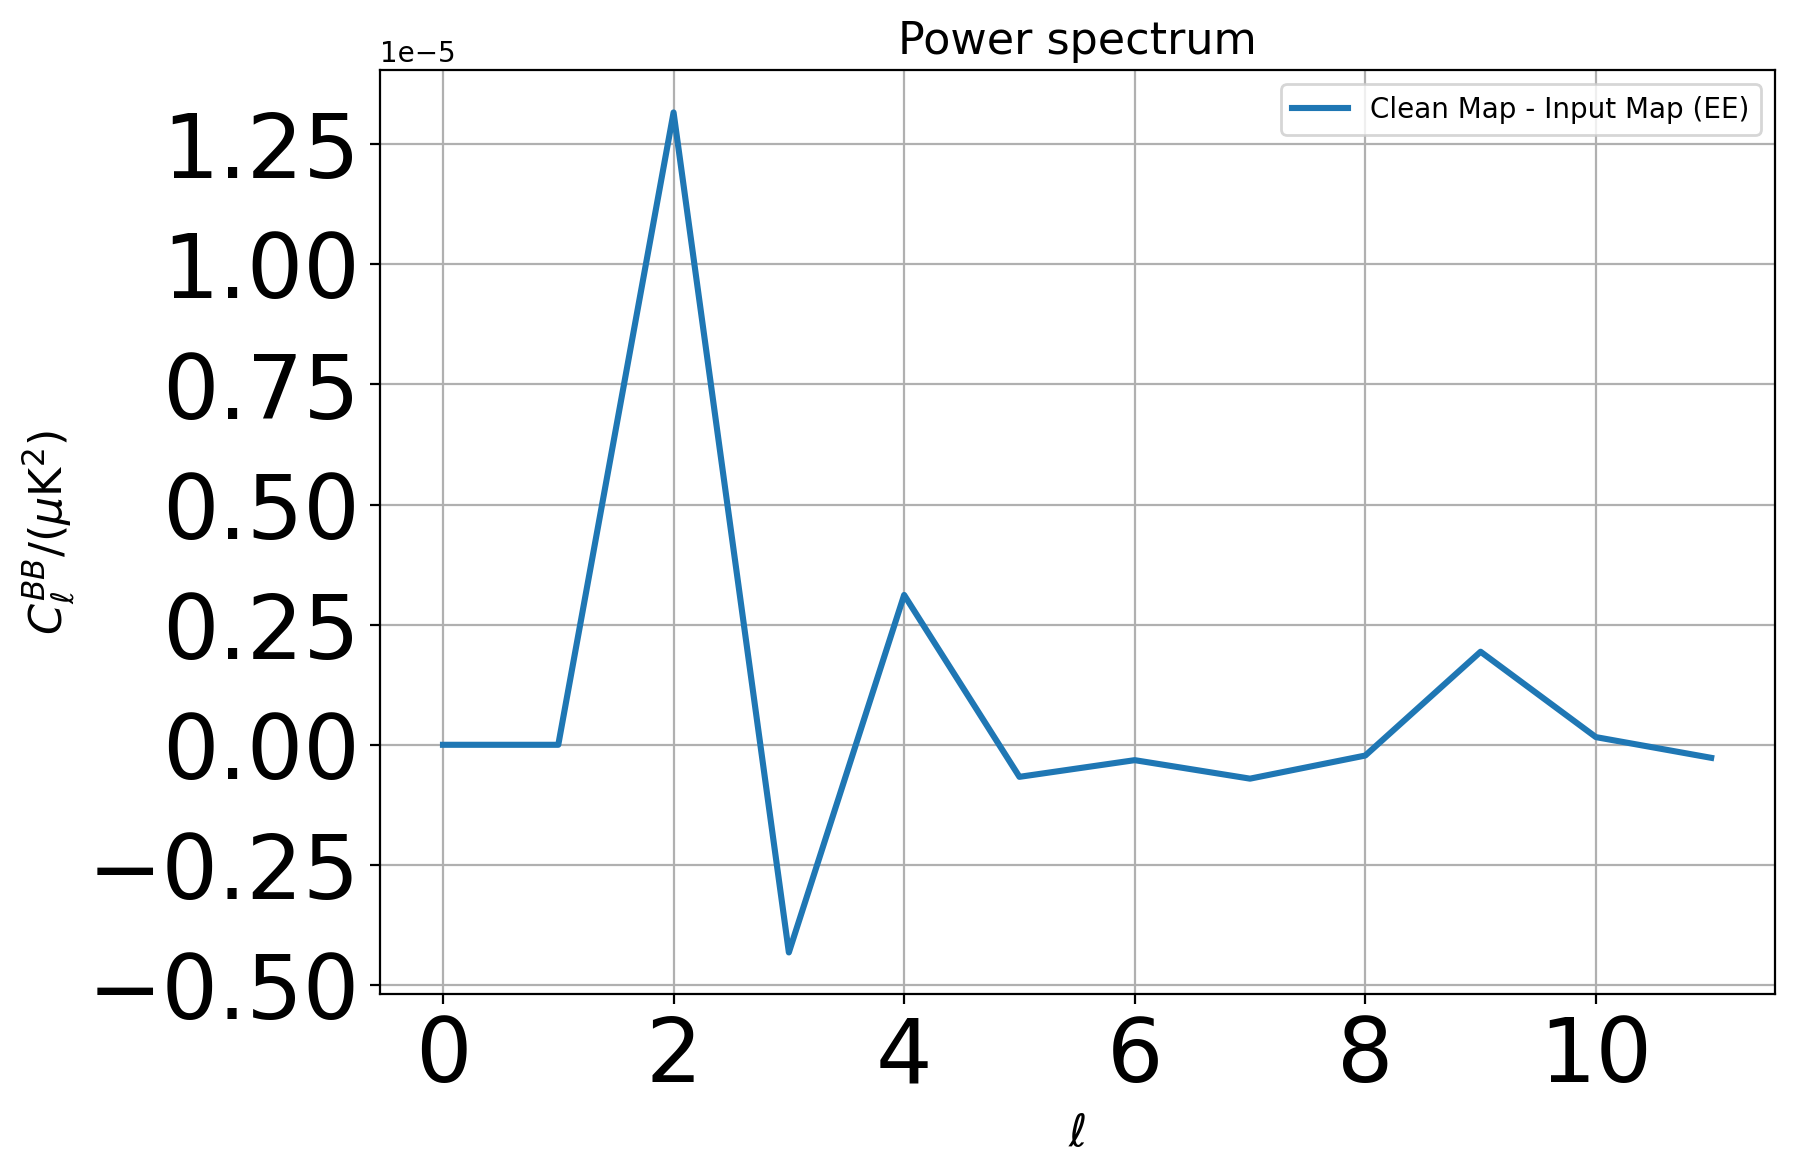

In [31]:
import matplotlib.pyplot as plt

#plot#
fig = plt.figure(figsize=(9, 6))

plt.plot(l, Clean_map_cl[2] - Input_map_cl[2] , lw = 2.2, label="Clean Map - Input Map (EE)")

plt.ylabel(r'$C_\ell^{BB}/ (\mu{\rm K}^2)$', fontsize=16)
plt.xlabel(r'$\ell$', fontsize=16)

plt.xticks(fontsize=32)
plt.yticks(fontsize=32)


plt.title("Power spectrum", fontsize=16)

plt.grid()
plt.legend()

plt.show()

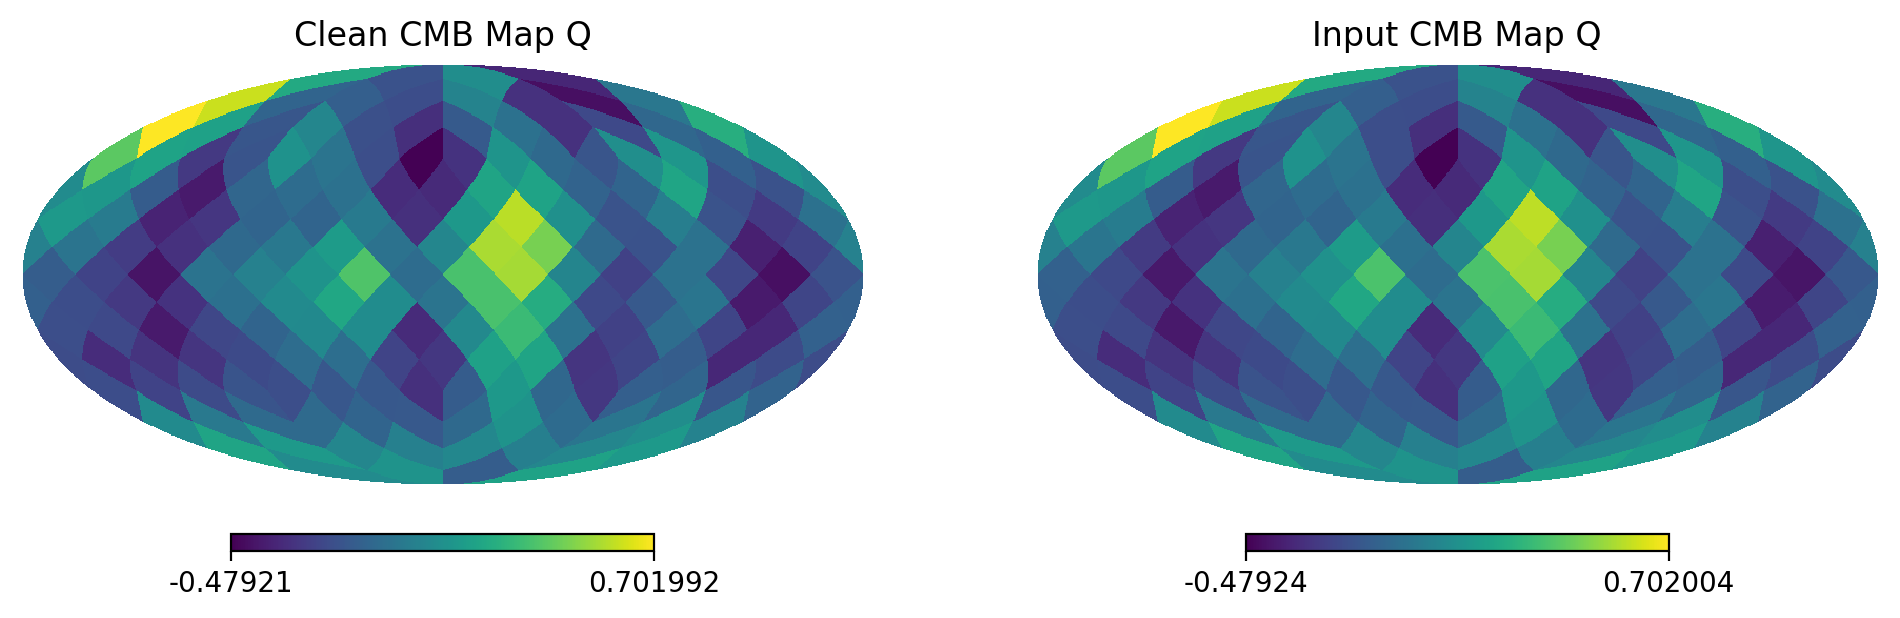

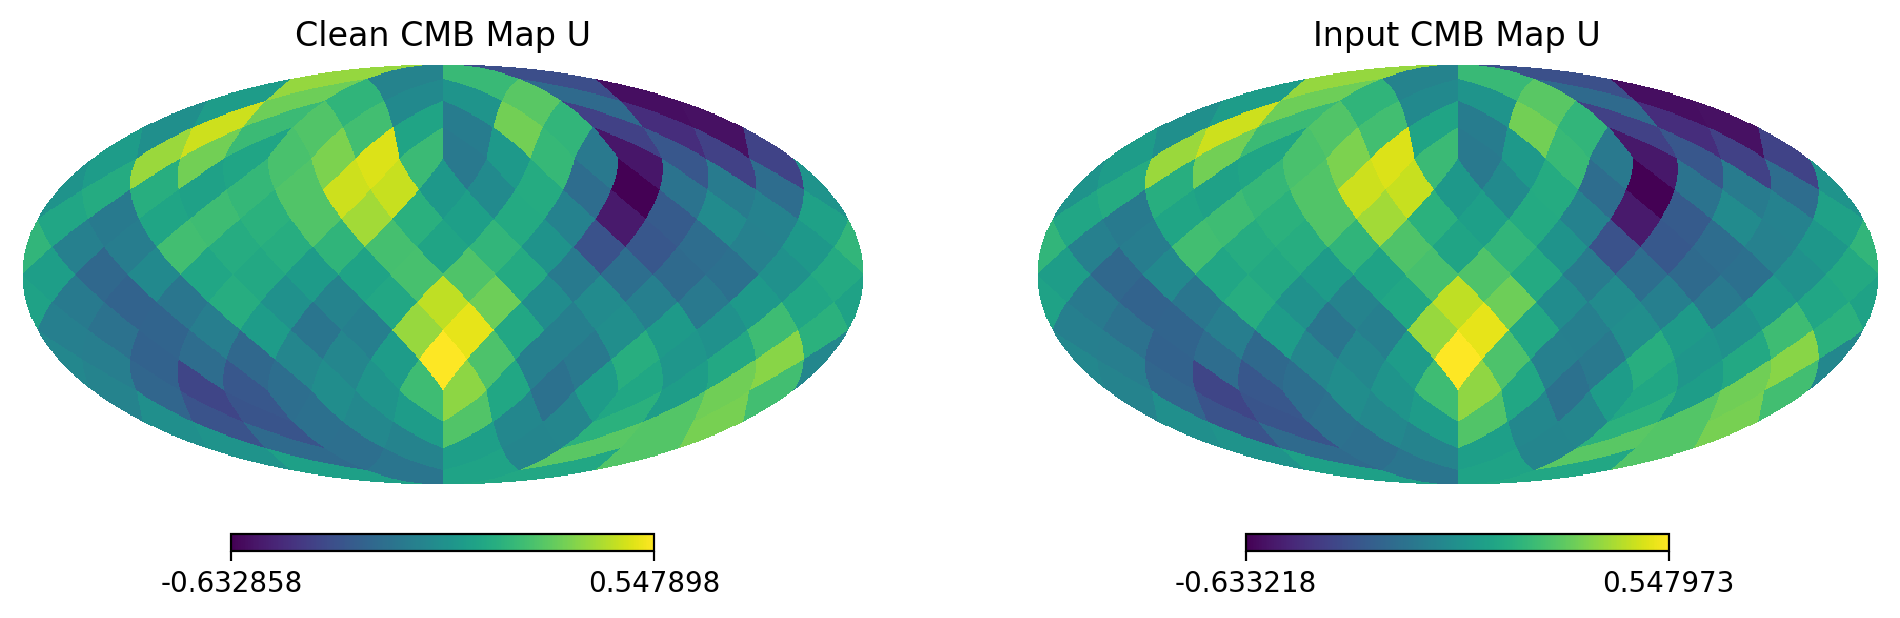

In [32]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(CMB_map_Q, title="Clean CMB Map Q", hold=True)

plt.axes(ax2)
hp.mollview(cmb_map[1], title="Input CMB Map Q", hold=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(CMB_map_U, title="Clean CMB Map U",hold=True)

plt.axes(ax2)
hp.mollview(cmb_map[2], title="Input CMB Map U",hold=True)

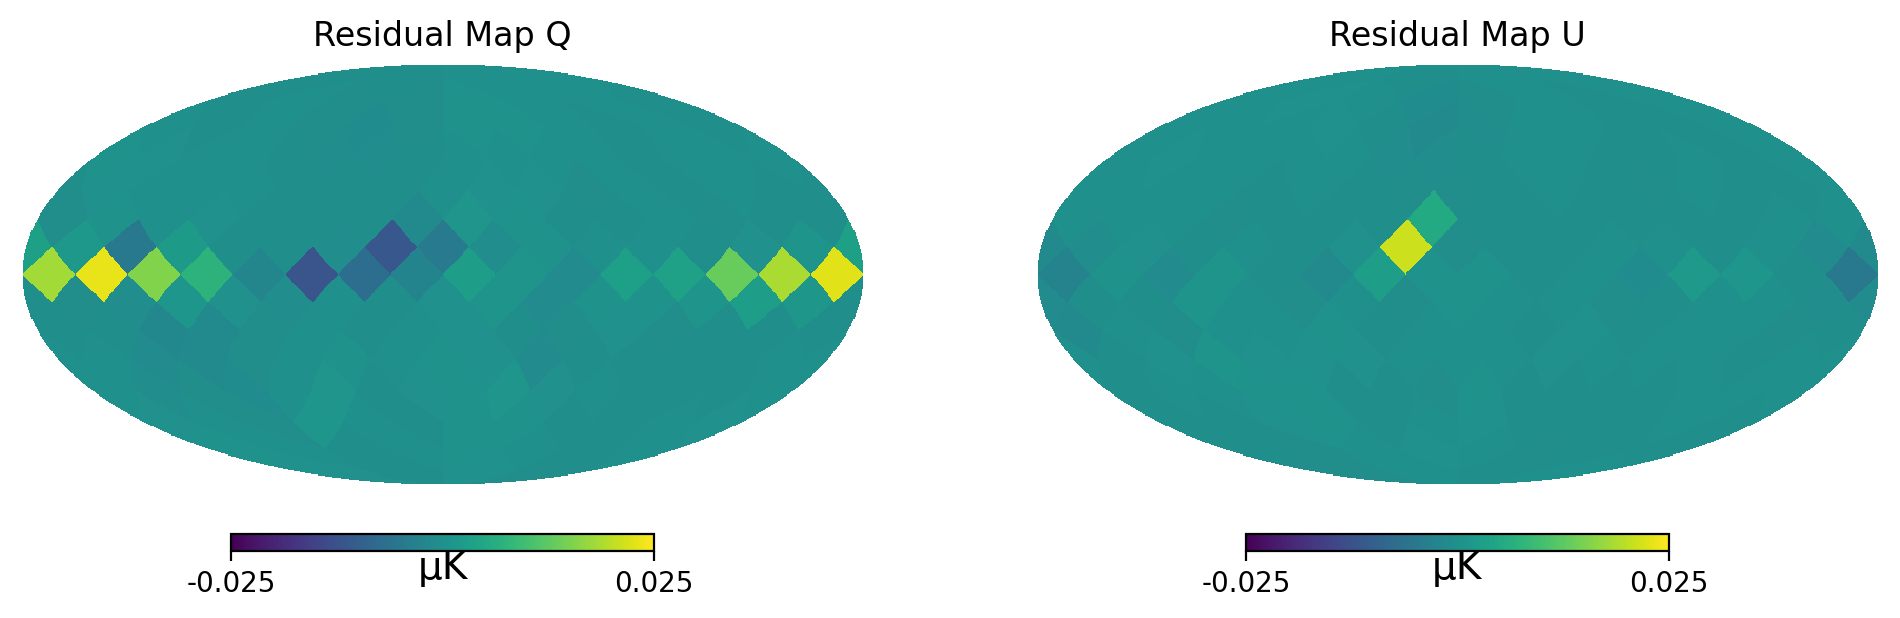

In [33]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

"""
plt.axes(ax1)
hp.mollview(cmb_map[1] - CMB_map_Q, title="Residual Map Q", unit="μK", hold=True)

plt.axes(ax2)
hp.mollview(cmb_map[2] - CMB_map_U, title="Residual Map U", unit="μK", hold=True)

"""
plt.axes(ax1)
hp.mollview(cmb_map[1] - CMB_map_Q, title="Residual Map Q", min = -0.025, max = 0.025, unit="μK", hold=True)

plt.axes(ax2)
hp.mollview(cmb_map[2] - CMB_map_U, title="Residual Map U", min = -0.025, max = 0.025, unit="μK", hold=True)

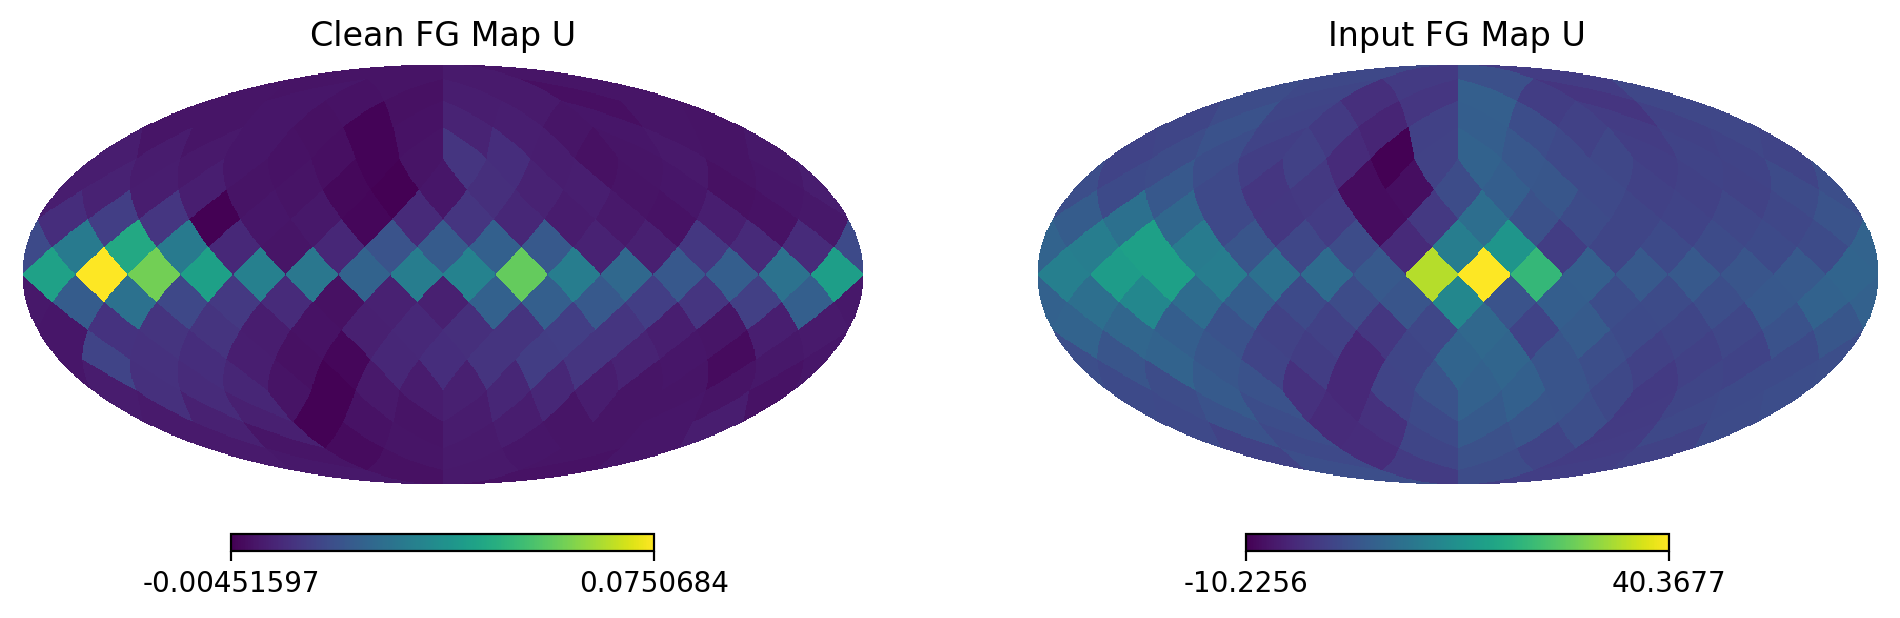

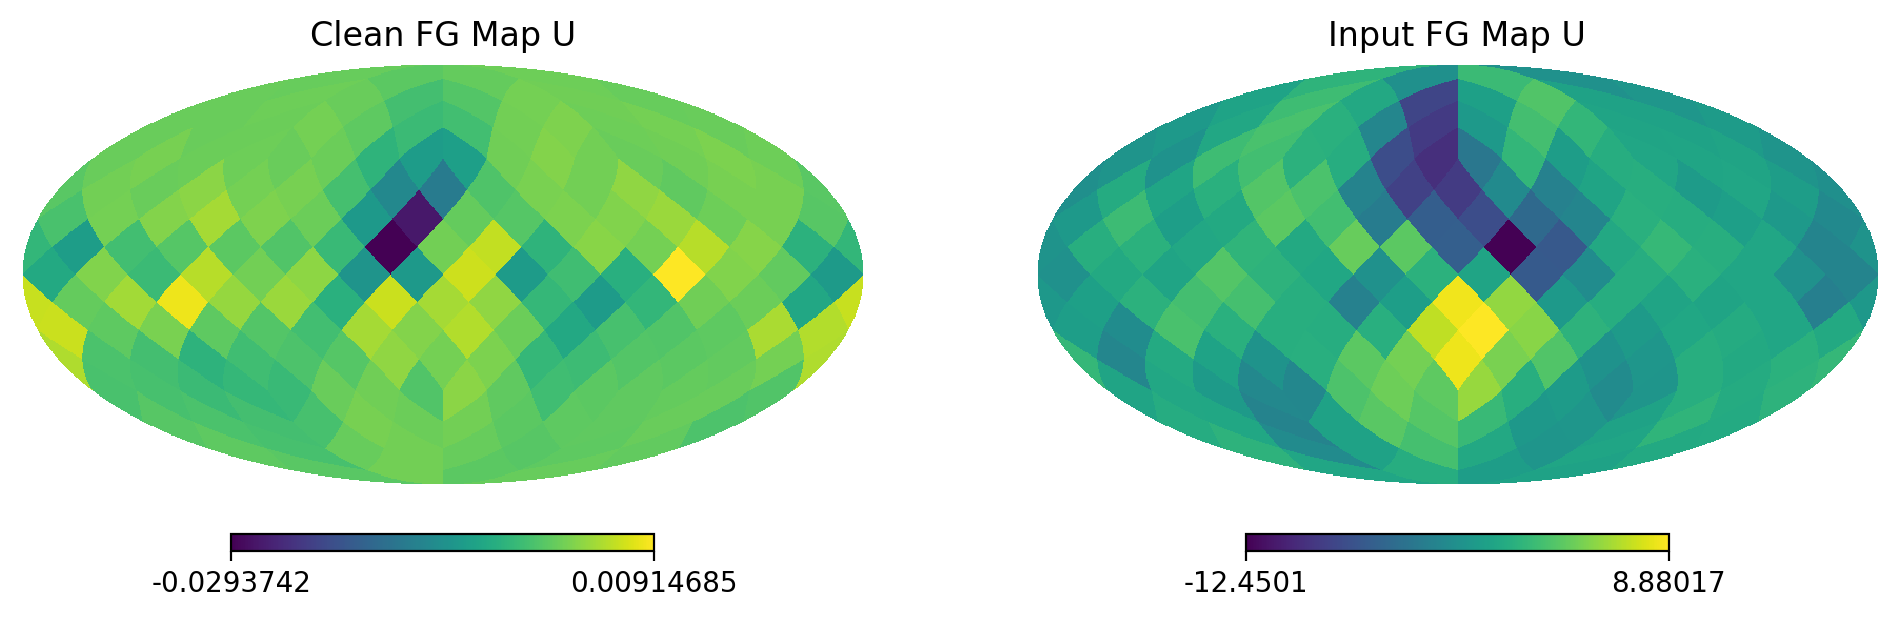

In [34]:
# FG Map

FG_map_Q = clean_map[N_pix*2:N_pix*3]
FG_map_U = clean_map[N_pix*3:N_pix*4]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(FG_map_Q, title="Clean FG Map U",hold=True)

plt.axes(ax2)
hp.mollview(map_Synch_40GHz[1], title="Input FG Map U",hold=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(FG_map_U, title="Clean FG Map U",hold=True)

plt.axes(ax2)
hp.mollview(map_Synch_40GHz[2], title="Input FG Map U",hold=True)

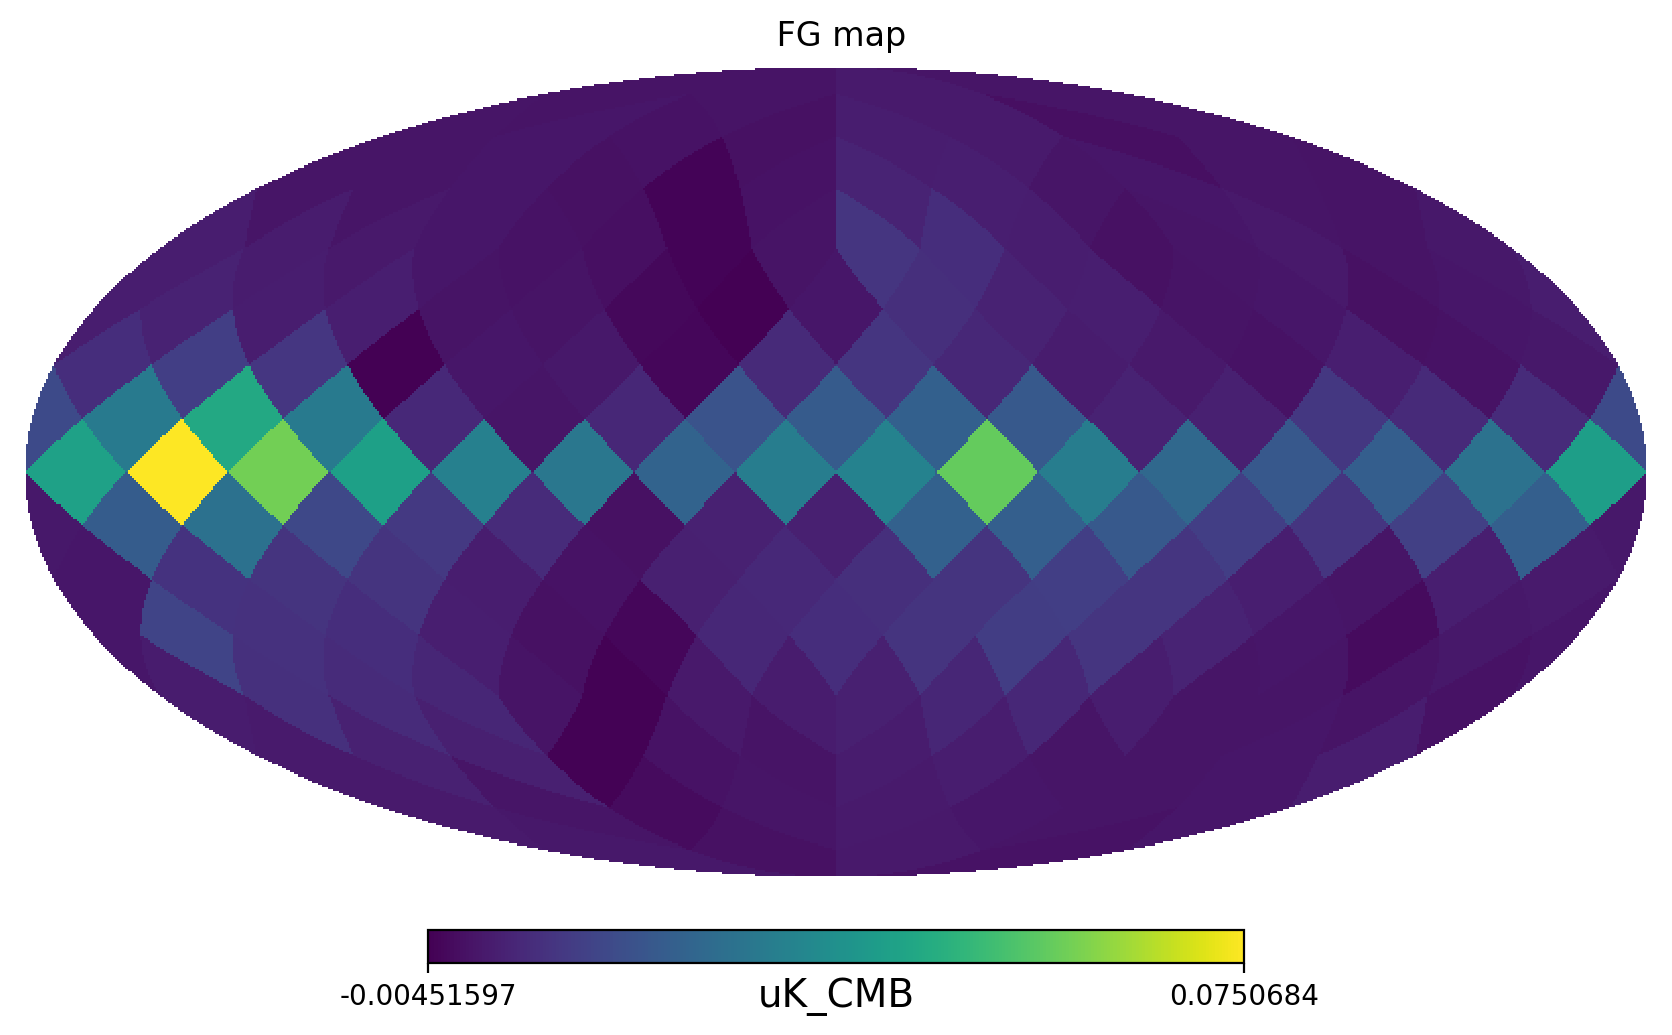

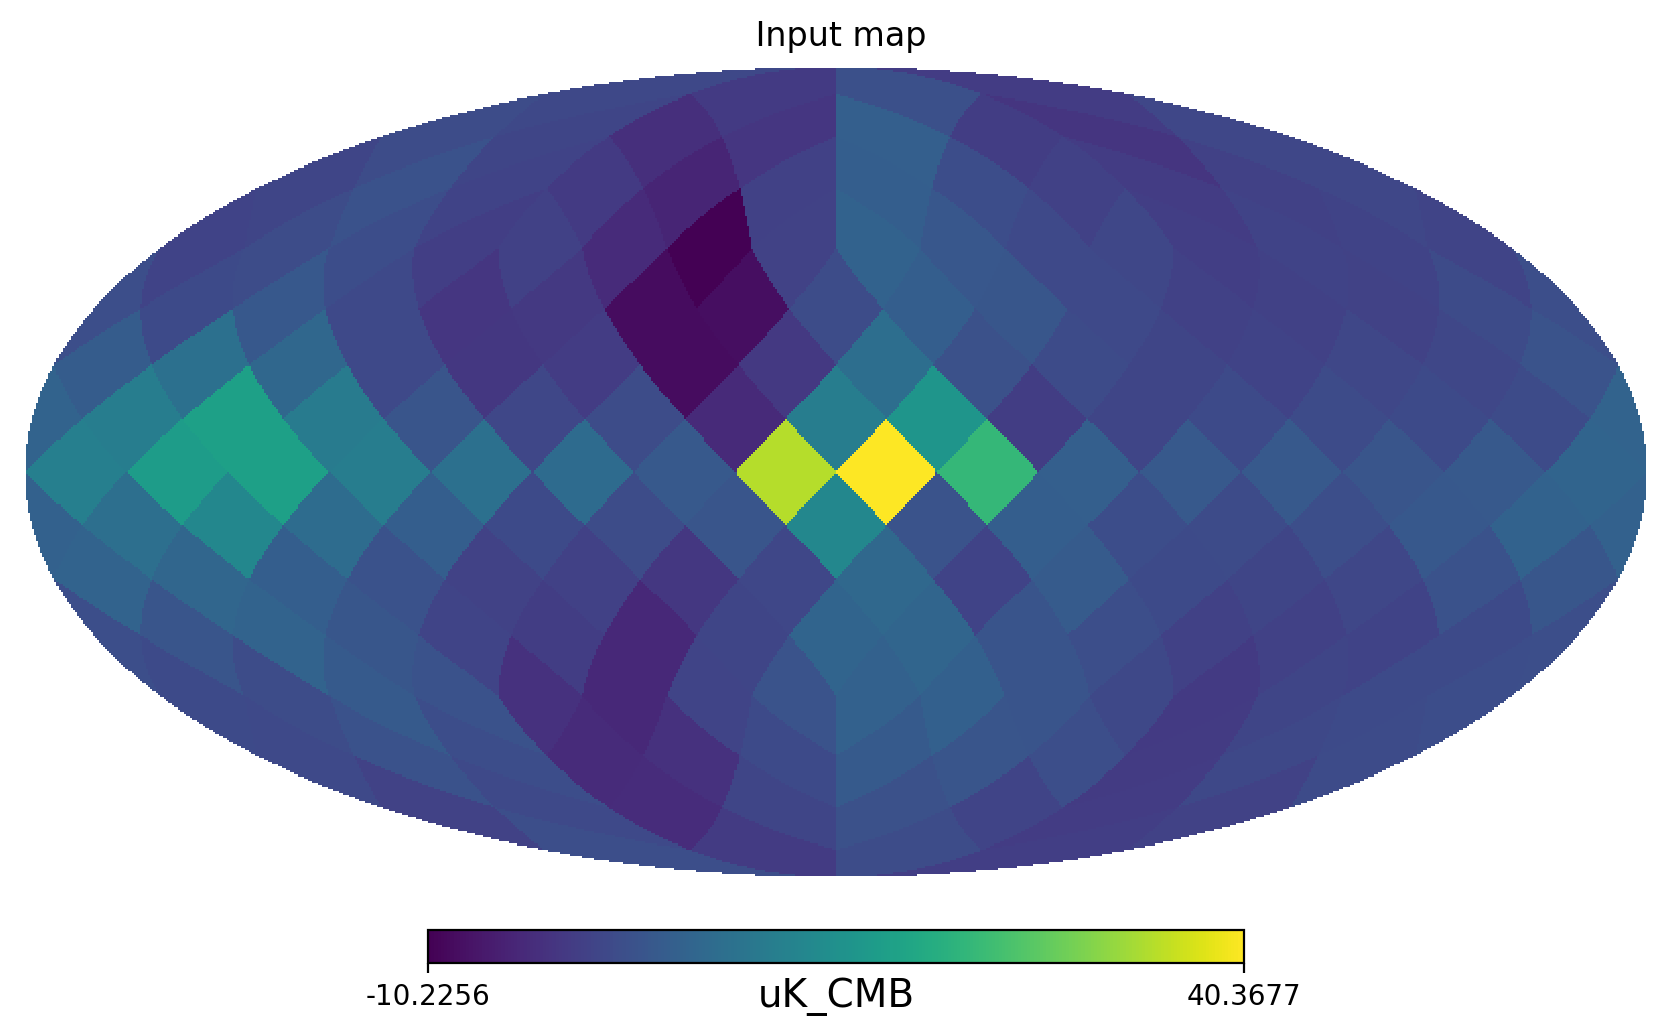

In [34]:
FG_map_Q = clean_map[N_pix*2:N_pix*3]
FG_map_U = clean_map[N_pix*3:N_pix*4]

hp.mollview(FG_map_Q, title=" FG map", unit = map_Synch_40GHz.unit)
hp.mollview(map_Synch_40GHz[1], title=" Input map", unit = map_Synch_40GHz.unit)

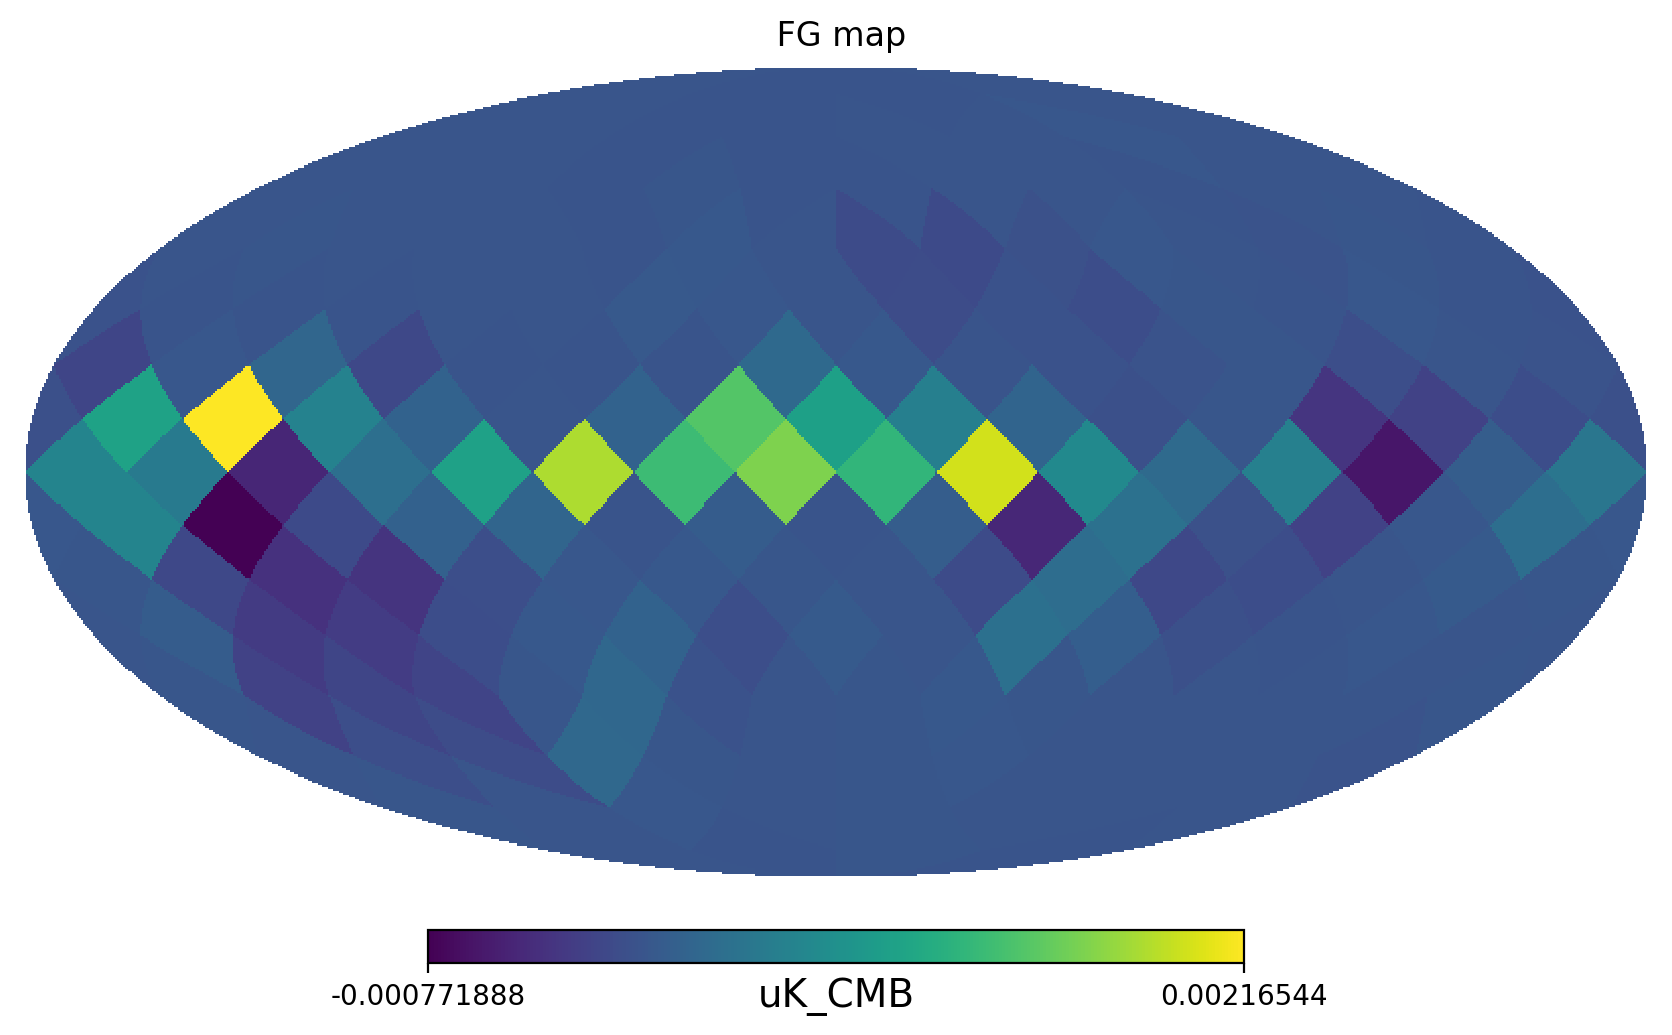

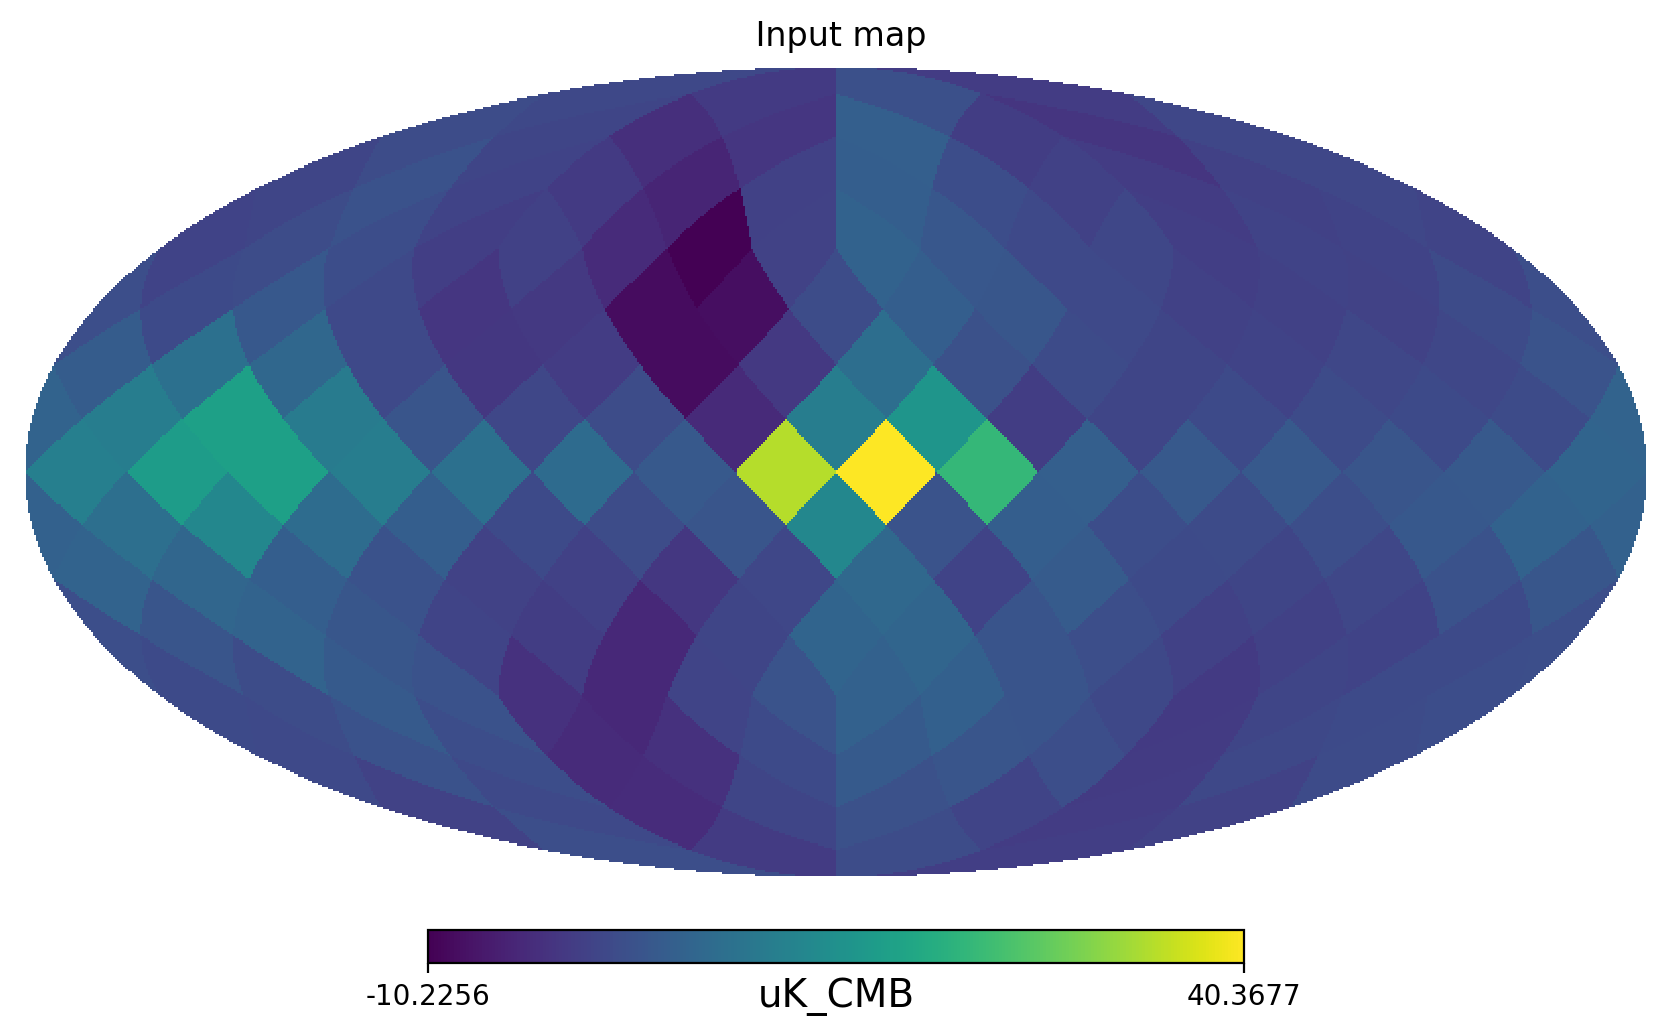

In [35]:
FG_map_Q = clean_map[N_pix*4:N_pix*5]
FG_map_U = clean_map[N_pix*5:N_pix*6]

hp.mollview(FG_map_Q, title=" FG map", unit = map_Synch_40GHz.unit)
hp.mollview(map_Synch_40GHz[1], title=" Input map", unit = map_Synch_40GHz.unit)